# Transfer learning for lung segmentation with fastai and pytorch

## Dependencies 

In [ ]:
# upgradding fastai
!pip install fastai --upgrade


In [ ]:
# imports

from fastai.vision.widgets import *
from fastai.vision.all import*
from google.colab import files

import cv2
import os

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np
import pickle

from torch import nn
from torchvision.models.resnet import resnet34

import torch

import torch.nn.functional as F

## Working with the dataset

In [ ]:
# unzip  dataset
!unzip /content/drive/MyDrive/rgb.zip

unzip:  cannot find or open /content/drive/MyDrive/rgb.zip, /content/drive/MyDrive/rgb.zip.zip or /content/drive/MyDrive/rgb.zip.ZIP.


In [ ]:
# Equalization function
def histeq (img):
    if isinstance(img, torch.Tensor):
      img = np.asarray(img)
      
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imhist = cv2.equalizeHist(imgray)
    imhist_rgb = cv2.cvtColor(imhist,cv2.COLOR_GRAY2BGR)
    return imhist_rgb

# Binarization function
def binarize_mask(mask):
    mask = cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)  # Binarizar la máscara   
    return mask/255


In [ ]:
# Adappting our dataset
# import shutil
# path = Path("/content/rgb")
# imgurls = os.listdir('/content/rgb/img')


# for i in imgurls:
#   #procesamiento de las imágenes
#   img = cv2.imread(str(path/'img')+'/'+i)
#   img = histeq(img) 
#   cv2.imwrite(str(path/'img')+'/'+i, img)
#   #procesamiento de las máscaras
#   msk = cv2.imread(str(path/'msk')+'/'+i)
#   msk = binarize_mask(msk)
#   cv2.imwrite(str(path/'msk')+'/'+i,msk)

# shutil.copytree('/content/rgb/', '/content/drive/MyDrive/trainseg/')



In [ ]:
# creating valid.txt
path = Path("/content/drive/MyDrive/trainseg")  # Ruta a la carpeta que contiene los datos
names = os.listdir(path/'img')
f = open(path/'valid.txt','w')
for filenames in names:
  f.write(filenames +'\n')
f.close()

In [ ]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [ ]:
print(valid_fnames[:5])
print(len(valid_fnames))

['605.png', '1067.png', '158.png', '79.png', '354.png']
1154


In [ ]:
path_im = path/'img'
path_lbl = path/'msk'
print('path de las imagenes:',path_im)
print('path de las target:',path_lbl )

path de las imagenes: /content/drive/MyDrive/trainseg/img
path de las target: /content/drive/MyDrive/trainseg/msk


In [ ]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)
print(fnames[:1])

[Path('/content/drive/MyDrive/trainseg/img/605.png')]


dimjensiones de la imagen: (128, 128, 3)


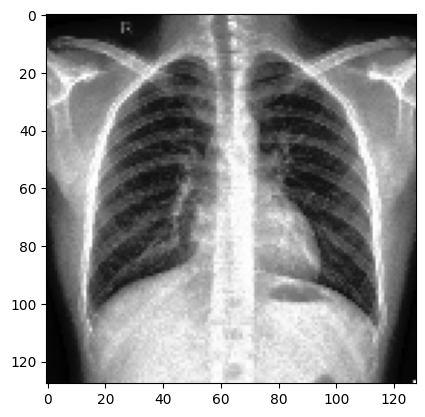

In [ ]:
img_fn = fnames[67]
img = cv2.imread(str(img_fn))
img1 = np.asarray(img)
print('dimjensiones de la imagen:',np.shape(img1))
plt.imshow(img)

In [ ]:
# Function to get labels from the dataset
def get_msk(o):
  return path/'msk'/f'{o.stem}{o.suffix}'

/content/drive/MyDrive/trainseg/msk/461.png
dimensiones de la mascara de segmentacion: (128, 128, 3)


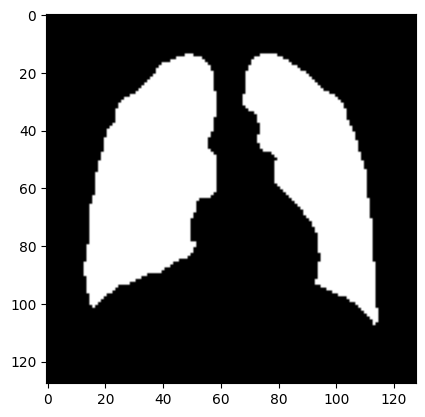

In [ ]:
print(str(get_msk(img_fn)))
msk = cv2.imread(str(get_msk(img_fn)))

msk1 = np.asarray(msk)
print('dimensiones de la mascara de segmentacion:',np.shape(msk))
plt.imshow(msk*255)
plt.show()

In [ ]:
# codes for each class
codes = np.asarray(['background','estructure','Void'])
codes



array(['background', 'estructure', 'Void'], dtype='<U10')

In [ ]:
# creating our datablock
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=(128,128)), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = camvid.dataloaders(str(path),bs=4)

In [ ]:
dls.vocab = codes
dls.vocab

array(['background', 'estructure', 'Void'], dtype='<U10')

In [ ]:
#creando diccionarios para los codigos de clase 
name2id = {v:k for k,v in enumerate(codes)}
name2id 

{'background': 0, 'estructure': 1, 'Void': 2}

In [ ]:
void_code = name2id['Void']

In [ ]:
# performance metric function
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [ ]:
#optimazer
opt = ranger

## Training experiments

###Simple fine tuning

In [ ]:
learn1 = unet_learner(dls, resnet18, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


SuggestedLRs(valley=0.0002754228771664202)

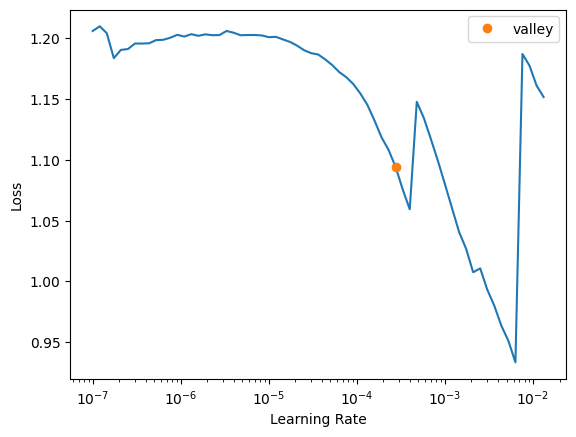

In [ ]:
learn1.lr_find()

In [ ]:
lr = 3e-3
learn1.lr=lr
learn1.fine_tune(10)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.258279,0.081707,0.969319,01:25


epoch,train_loss,valid_loss,acc_camvid,time
0,0.080856,0.056834,0.977714,00:29
1,0.079020,0.071685,0.971786,00:29
2,0.063921,0.050086,0.980029,00:30
3,0.061628,0.041995,0.983567,00:29
4,0.050853,0.041667,0.983876,00:29
5,0.052437,0.036866,0.985749,00:29
6,0.045271,0.035830,0.986170,00:29
7,0.044950,0.035204,0.986516,00:29
8,0.041648,0.034421,0.986876,00:29
9,0.040217,0.033986,0.987067,00:29


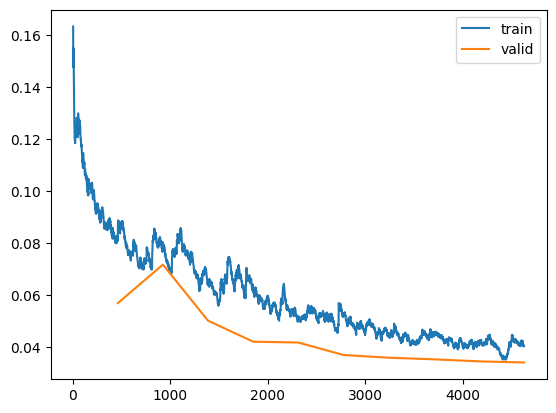

In [ ]:
learn1.recorder.plot_loss()

### Fine tuning with gradual unfreeze

In [ ]:
learn2 = unet_learner(dls, resnet18, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.00013182566908653826)

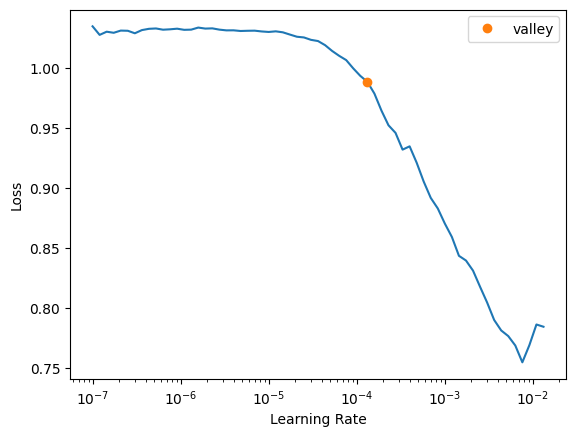

In [ ]:
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.225346,0.081039,0.968785,00:27
1,0.237515,0.058237,0.977107,00:27
2,0.071619,0.053422,0.978314,00:27
3,0.055347,0.041291,0.983770,00:27
4,0.054574,0.039340,0.984392,00:28


SuggestedLRs(valley=0.0002290867705596611)

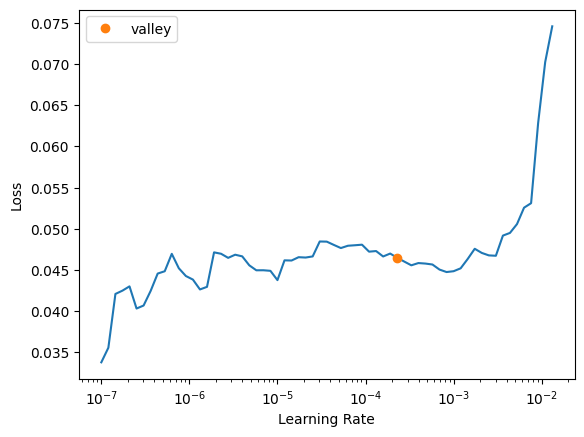

In [ ]:
learn2.unfreeze()
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.048111,0.038553,0.984792,00:29
1,0.046012,0.038756,0.984754,00:29
2,0.045939,0.038274,0.984930,00:29
3,0.047356,0.037982,0.985057,00:30
4,0.046577,0.037891,0.985129,00:29
5,0.046140,0.037837,0.985170,00:29


### Fine tuning with driscriminative learning rate

In [ ]:
learn3 = unet_learner(dls, resnet18, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn3.fit_one_cycle(5, 3e-3)
learn3.unfreeze()
learn3.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.433481,0.087269,0.966439,00:27
1,0.085595,0.054100,0.978508,00:27
2,0.063770,0.044850,0.982939,00:28
3,0.049367,0.037728,0.985230,00:27
4,0.043175,0.036872,0.985918,00:28


epoch,train_loss,valid_loss,acc_camvid,time
0,0.046858,0.036888,0.985764,00:30
1,0.045233,0.036180,0.986108,00:29
2,0.043068,0.035906,0.986198,00:30
3,0.043861,0.035775,0.986133,00:30
4,0.047824,0.035364,0.986365,00:30
5,0.042191,0.034952,0.986551,00:30
6,0.040459,0.035137,0.986457,00:30
7,0.042428,0.034895,0.986469,00:30
8,0.040046,0.035152,0.986359,00:30
9,0.041329,0.034863,0.986522,00:29


Another lr slice

In [ ]:
learn3 = unet_learner(dls, resnet18, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)
learn3.fit_one_cycle(5, 3e-3)
learn3.unfreeze()
learn3.fit_one_cycle(12, lr_max=slice(1e-5,1e-3))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.149039,0.075176,0.972643,00:27
1,0.083372,0.080615,0.972168,00:27
2,0.061446,0.045119,0.983230,00:27
3,0.050502,0.037376,0.985324,00:27
4,0.048669,0.035802,0.986105,00:27


epoch,train_loss,valid_loss,acc_camvid,time
0,0.044678,0.035716,0.986053,00:29
1,0.048382,0.040902,0.983930,00:29
2,0.048364,0.039237,0.985168,00:29
3,0.046157,0.036650,0.985985,00:29
4,0.042655,0.039570,0.985383,00:29
5,0.040908,0.034341,0.986694,00:29
6,0.043392,0.033987,0.987106,00:29
7,0.042041,0.033736,0.987124,00:30
8,0.038290,0.032981,0.987344,00:30
9,0.037682,0.033479,0.987192,00:30


### Deeper architectures

Resnet34

In [ ]:
learn4 = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 391MB/s]


SuggestedLRs(valley=0.00013182566908653826)

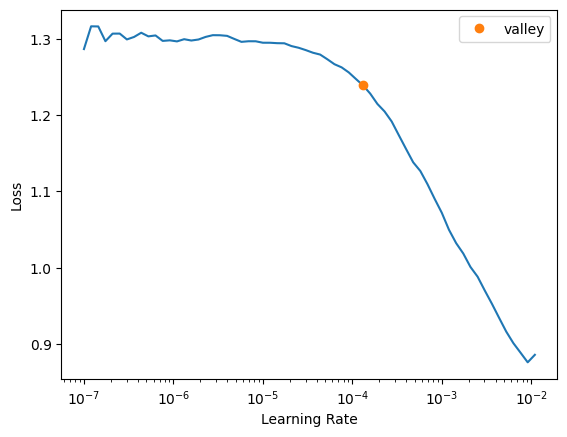

In [ ]:
learn4.lr_find()

In [ ]:
learn4.lr = 2e-3
learn4.fit_one_cycle(5)


epoch,train_loss,valid_loss,acc_camvid,time
0,1.756186,0.192367,0.932390,00:33
1,0.078611,0.047351,0.981938,00:32
2,0.054829,0.041588,0.983944,00:33
3,0.046564,0.036518,0.985738,00:33
4,0.045574,0.035161,0.986359,00:32


In [ ]:
learn4.unfreeze()

SuggestedLRs(valley=0.0004786300996784121)

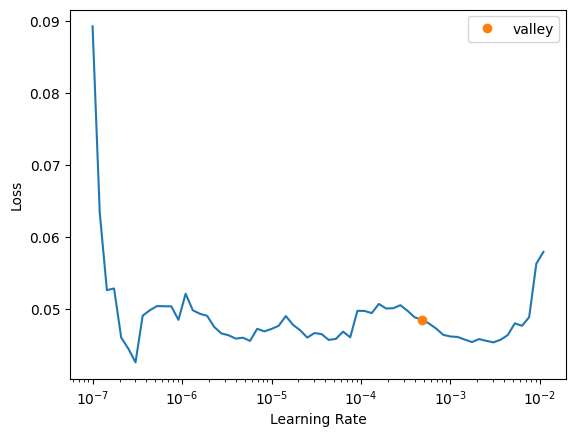

In [ ]:
learn4.lr_find()

In [ ]:

learn4.fit_one_cycle(12, lr_max=slice(4e-6,1e-3))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.043658,0.035246,0.986209,00:36
1,0.046061,0.046649,0.983186,00:35
2,0.052306,0.038015,0.985195,00:35
3,0.044963,0.037669,0.985384,00:36
4,0.045960,0.037096,0.985494,00:35
5,0.041898,0.036125,0.986074,00:36
6,0.042133,0.035060,0.986356,00:36
7,0.040172,0.034112,0.986823,00:35
8,0.036193,0.033724,0.987211,00:36
9,0.037730,0.033420,0.987111,00:36


In [ ]:
learn4.lr = 4e-4
learn4.fit_one_cycle(5)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.050109,0.040371,0.984649,00:35
1,0.042540,0.034889,0.986537,00:36
2,0.040697,0.035684,0.986540,00:36
3,0.038755,0.033252,0.987396,00:36
4,0.036465,0.032880,0.987521,00:36


resnet50

In [ ]:
learn5 = unet_learner(dls, resnet50, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 359MB/s]


SuggestedLRs(valley=9.120108734350652e-05)

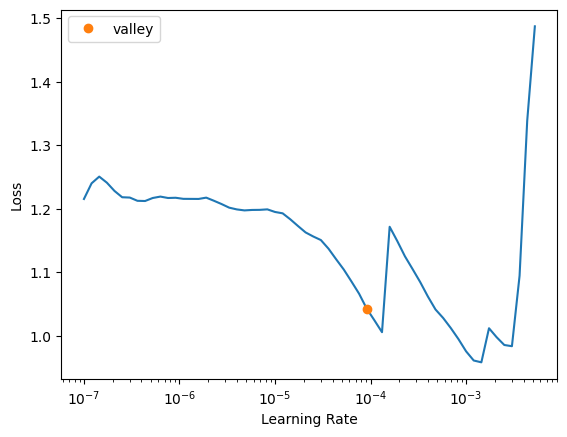

In [ ]:
learn5.lr_find()

In [ ]:
learn5.lr = 4e-4
learn5.fit_one_cycle(5)

epoch,train_loss,valid_loss,acc_camvid,time
0,4.104011,2.045583,0.625518,00:55
1,0.097736,0.058755,0.976644,00:54
2,0.054824,0.042540,0.983238,00:54
3,0.045800,0.037073,0.985627,00:54
4,0.043027,0.035800,0.986137,00:54


SuggestedLRs(valley=5.248074739938602e-05)

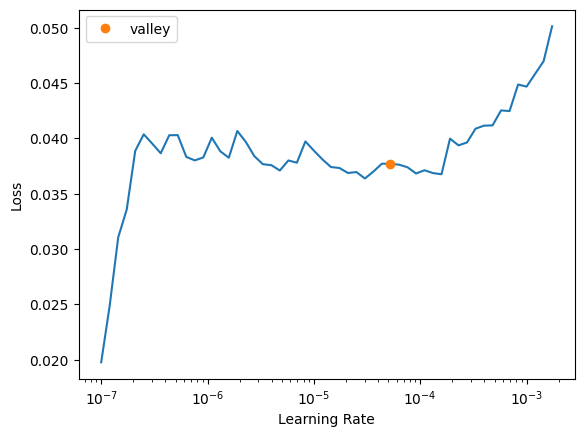

In [ ]:
learn5.unfreeze()
learn5.lr_find()

In [ ]:
learn5.fit_one_cycle(12, lr_max=slice(5.248074739938602e-05,2e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.046771,0.036226,0.986229,00:57
1,0.047953,0.037837,0.985145,00:57
2,0.052486,0.036640,0.986015,00:57
3,0.053649,0.042057,0.983648,00:58
4,0.045336,0.036259,0.986405,00:58
5,0.045581,0.035772,0.986296,00:57
6,0.042158,0.034368,0.986911,00:57
7,0.038635,0.035733,0.986397,00:57
8,0.035627,0.033222,0.987461,00:58
9,0.037836,0.033055,0.987557,00:58


resnet 50 with mixed precision 

In [ ]:
learn6 = unet_learner(dls, resnet50, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger).to_fp16()

SuggestedLRs(valley=5.248074739938602e-05)

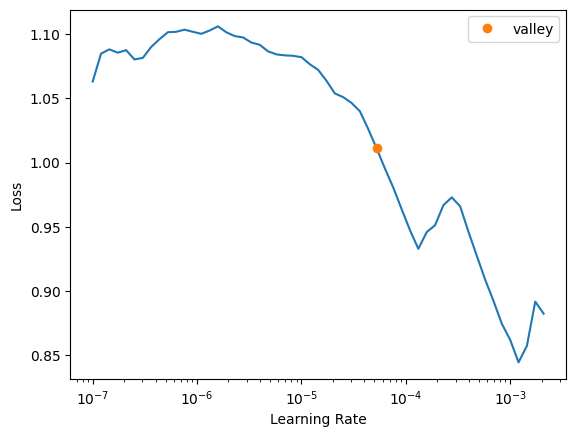

In [ ]:
learn6.lr_find()

In [ ]:
learn6.lr = 3e-5
learn6.fit_one_cycle(5)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.143804,0.085873,0.967875,00:55
1,0.085358,0.053045,0.979835,00:55
2,0.062432,0.050783,0.980355,00:55
3,0.049256,0.041455,0.983574,00:55
4,0.049871,0.039642,0.984429,00:55


SuggestedLRs(valley=5.248074739938602e-05)

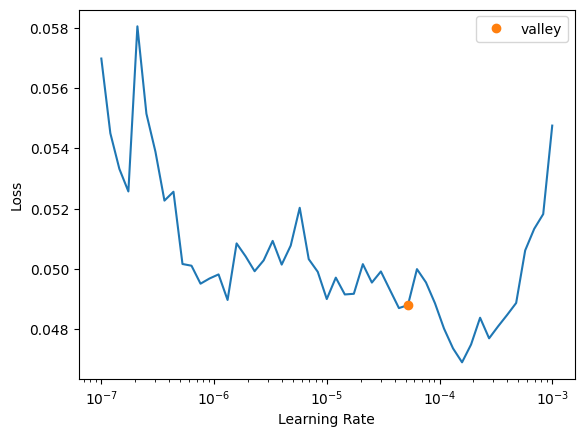

In [ ]:
learn6.unfreeze()
learn6.lr_find()

In [ ]:
learn6.fit_one_cycle(12, lr_max=slice(2e-7,1e-5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.053014,0.040632,0.984148,01:00
1,0.054752,0.041959,0.983627,01:00
2,0.049233,0.038896,0.984915,01:00
3,0.046462,0.039442,0.984388,01:00
4,0.046744,0.037166,0.985517,00:59
5,0.046463,0.037920,0.985093,01:00
6,0.044848,0.036874,0.985591,01:00
7,0.044086,0.036848,0.985640,01:00
8,0.041686,0.036603,0.985801,01:00
9,0.040455,0.036364,0.985906,01:00


In [ ]:
# saving our model
learn4.export('/content/drive/MyDrive/resnet34_Dlr.pkl')

##Inference

In [ ]:
img = cv2.imread('/content/test_seg.PNG')
img = histeq(img)
plt.imshow(img)
plt.show()
cv2.imwrite('/content/test_seg.PNG',img)

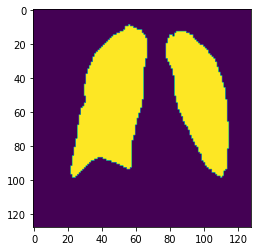

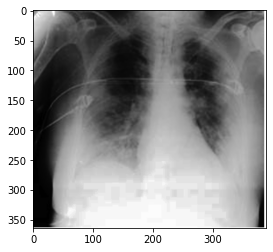

In [ ]:
# inferencia
#cargar modelo
path_model ='/content/drive/MyDrive/unet_resnet18_epoch10.pkl'
path_img = '/content/test_seg.PNG'
model_inf = load_learner(path_model)
#cargar imagen de inferencia

dl = model_inf.dls.test_dl(path_img)
#realizar inferencia

preds = model_inf.get_preds(dl=dl)
pred_1 = preds[0][0]
pred_arx = pred_1.argmax(dim=0)
plt.figure(1)
plt.imshow(pred_arx)
plt.figure(2)
plt.imshow(cv2.imread(path_img))
plt.show()

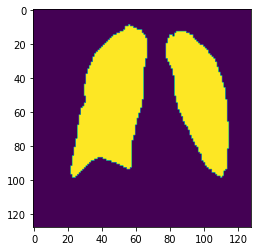

In [ ]:
# Inference fucntion
path_model ='/content/drive/MyDrive/unet_resnet18_epoch10.pkl'
model_inf = load_learner(path_model)  

def get_mask(img, model):
  img = histeq(img)
  cv2.imwrite('img.tif',img)
  #realizar inferencia
  preds = model_inf.get_preds(dl=dl)
  pred_1 = preds[0][0]
  pred_arx = pred_1.argmax(dim=0)
  mask = np.asarray(pred_arx)
  return mask
img1 = cv2.imread('/content/0_83.png')
plt.imshow(get_mask(img1,model_inf))

  



## Saving our architecture diagraph

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=8e033f3203b4e521768541f3d1cf7f40def4f3485d44f1f03c34485b9a987763
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
from torchviz import make_dot
from fastai.vision.all import *
x,y = dls.one_batch()
preds = learn.model(x)
img_arquitecture =make_dot(preds, params=dict(learn.model.named_parameters()))
type(img_arquitecture)


graphviz.graphs.Digraph

In [ ]:
from graphviz import Digraph

# Create the Digraph object
dot = img_arquitecture

# Render the graph and save it as a .png file
dot.render('nombre_del_archivo', format='png')

'nombre_del_archivo.png'